Второе домашнее задание — самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются. 
Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:

- построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров; 
- при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
- а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.


In [1]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import pickle
import json
from copy import copy
import requests
from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

## 1. Прочитайте и проанализируйте данные
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года; 
в тестовый — турниры с dateStart из 2020 года.


In [95]:
with open('/content/drive/MyDrive/MADE/chgk/results.pkl', 'rb') as f:
    results = pickle.load(f)

with open('/content/drive/MyDrive/MADE/chgk/players.pkl', 'rb') as f:
    players = pickle.load(f)
    
with open('/content/drive/MyDrive/MADE/chgk/tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)

In [ ]:
tournaments[5000]

{'dateEnd': '2019-04-30T18:00:00+03:00',
 'dateStart': '2019-04-26T18:00:00+03:00',
 'id': 5000,
 'name': 'Чёрная Быль',
 'orgcommittee': [{'id': 59436,
   'name': 'Олег',
   'patronymic': 'Сергеевич',
   'surname': 'Роднов'}],
 'questionQty': {'1': 12, '2': 12, '3': 12},
 'season': '/seasons/52',
 'synchData': {'allVerdictsDone': None,
  'allowAppealCancel': True,
  'allowNarratorErrorAppeal': False,
  'dateArchivedAt': '2019-05-05T23:59:59+03:00',
  'dateDownloadQuestionsFrom': '2019-04-24T00:00:00+03:00',
  'dateDownloadQuestionsTo': '2019-04-27T20:00:00+03:00',
  'dateRequestsAllowedTo': '2019-04-30T23:59:59+03:00',
  'hideQuestionsTo': '2019-05-02T23:59:59+03:00',
  'hideResultsTo': '2019-05-02T23:59:59+03:00',
  'instantControversial': True,
  'resultFixesTo': '2019-05-11T23:59:59+03:00',
  'resultsRecapsTo': '2019-05-02T23:59:59+03:00'},
 'type': {'id': 3, 'name': 'Синхрон'}}

In [3]:
TRAIN_DATE = "2019-01-01"
VAL_DATE ="2020-01-01"


def get_data(tournaments, train_date, val_date):
    DATE_TRAIN = datetime.strptime(train_date, "%Y-%m-%d")
    DATE_VAL = datetime.strptime(val_date, "%Y-%m-%d")
    train = []
    val = []
    pid = 0
    tid = 0
    for key in tournaments.keys():
        date = datetime.fromisoformat(tournaments[key]['dateStart']).replace(tzinfo=None)
        if date >= DATE_TRAIN:
            if not results[key]:
                continue
            questions = set()
            for team in results[key]:
                if team.get('mask', False):
                    questions.add(len(team['mask']))
            if len(questions) > 1:
                continue
            tour = {}
            tour['id'] = tournaments[key]['id']
            tour['teams'] = []
            for team in results[key]:
                if team.get('mask') is None or team.get('mask').replace('1', '').replace('0', ''):
                    continue
                if team['team']['id'] > tid:
                    tid = team['team']['id']
                team_data = {}
                team_data['id'] = team['team']['id']
                team_data['mask'] = team['mask']
                team_data['members'] = []
                for member in team['teamMembers']:
                    player_id = member['player']['id']
                    if player_id > pid:
                        pid = player_id
                    team_data['members'].append(player_id)
                tour['teams'].append(team_data)
            
            if not tour['teams']:
                continue
            
            if date < DATE_VAL:
                train.append(tour)
            else:
                val.append(tour)
    return train, val

train, val = get_data(tournaments, TRAIN_DATE, VAL_DATE)

In [ ]:
with open('/content/drive/MyDrive/MADE/chgk/train.json', 'w') as f:
    json.dump(train, f)
    
with open('/content/drive/MyDrive/MADE/chgk/val.json', 'w') as f:
    json.dump(val, f)

In [3]:
with open('/content/drive/MyDrive/MADE/chgk/train.json', 'r') as f:
    train = json.load(f)
    
with open('/content/drive/MyDrive/MADE/chgk/val.json', 'r') as f:
    val = json.load(f)

In [4]:
members = defaultdict(set)
correct_ratio = []
questions_cnt = []
questions_ratio = []
team_cnt = []

for tournament in train:
    answers = []
    for team in tournament['teams']:
        ans = list(map(int, team['mask']))
        questions_len = len(ans)
        correct = sum(ans)
        correct_ratio.append(correct / questions_len)
        answers.append(ans)
        for member in team['members']:
            members[member].add(tournament['id'])
    questions_cnt.append(questions_len)  
    questions_ratio += np.array(answers).mean(axis=0).tolist()
for member, teams in members.items():
    team_cnt.append(len(teams))

Mean number of questions: 47.


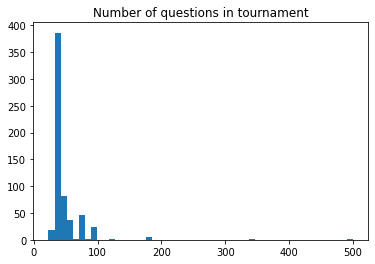

Maximum number of questions: 500.


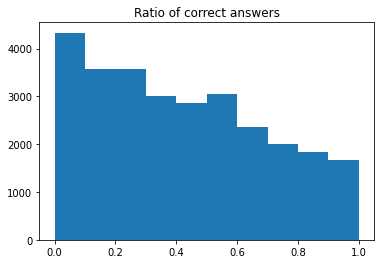

Mean number of teammates 6.22


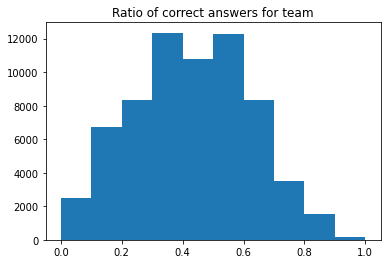

In [ ]:
print(f'Mean number of questions: {np.mean(questions_cnt):.0f}.')
plt.hist(questions_cnt, bins=50)
plt.title('Number of questions in tournament')
plt.show();

print(f'Maximum number of questions: {np.max(questions_cnt)}.')
plt.hist(questions_ratio, bins=10)
plt.title('Ratio of correct answers')
plt.show();

print(f'Mean number of teammates {np.mean(team_cnt):.2f}')
plt.hist(correct_ratio, bins=10)
plt.title('Ratio of correct answers for team')
plt.show();

## 2. Постройте baseline-модель

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [84]:
members = set()
ans = defaultdict(int)
correct = defaultdict(int)
tours = defaultdict(int)

for tournament in train:
    for team in tournament['teams']:
        for member in team['members']:
            ans[member] += len(team['mask'])
            correct[member] = sum(list(map(int, team['mask'])))
            tours[member] += 1
            members.add(member)

member_2_index = {member: index for index, member in enumerate(members)}
index_2_member = {index: member for member, index in member_2_index.items()}
member_ans_1000 = [member for member, answers in ans.items() if answers > 1000]

In [6]:
# Econder & decoder
member_2_index = {member: index for index, member in enumerate(members)}
index_2_member = {index: member for member, index in member_2_index.items()}
member_ans_1000 = [member for member, answers in ans.items() if answers > 1000]

In [ ]:
print(f'Players with 1000 answers: {len(member_ans_1000)}')
print(f'Total number of players: {len(member_2_index)}')

Players with 1000 answers: 3245
Total number of players: 55151


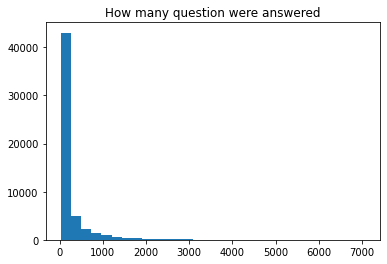

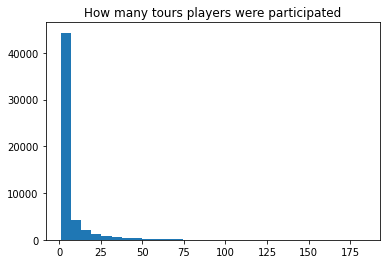

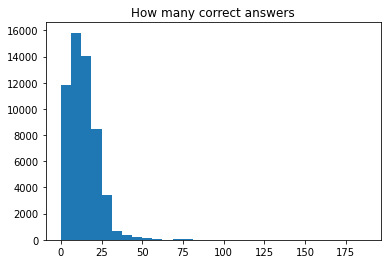

In [ ]:
plt.hist(ans.values(), bins=30);
plt.title('How many question were answered')
plt.show();

plt.hist(tours.values(), bins=30);
plt.title('How many tours players were participated')
plt.show();

plt.hist(correct.values(), bins=30);
plt.title('How many correct answers')
plt.show();

In [7]:
team_index = []
member_qest_cnt = []
member_2_indices = []
question_2_index = []
tournament_index = []

output = []

cnt = 0
for tournament in train:
    quest_counter = len(tournament['teams'][0]['mask'])
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        for q in range(quest_counter):
            for member in team['members']:
                member_2_indices.append(member_2_index[member])
                question_2_index.append(len(member_2_index) + quest_counter + q)
                member_qest_cnt.append(ans[member])
                tournament_index.append(tournament['id'])
                output.append(team_answers[q])
                team_index.append(team['id'])
    cnt += quest_counter

In [8]:
X = sparse.lil_matrix((len(member_2_indices), len(member_2_index) + cnt), dtype=int)
X[range(len(member_2_indices)), member_2_indices] = 1
X[range(len(member_2_indices)), question_2_index] = 1
y = np.array(output)
x_0, x_1 = X.shape 

In [17]:
lr = LogisticRegression(tol=1e-1, solver='saga', C=5)

In [18]:
lr.fit(X, y)

LogisticRegression(C=5, solver='saga', tol=0.1)

In [ ]:
question_rating = lr.coef_[0][len(member_2_index):]
rating = lr.coef_[0][:len(member_2_index)]
leaderboard = []
for index, member in index_2_member.items():
    item = {"id": member, "score": rating[index], "name": f'{players[member]["name"]} {players[member]["surname"]}', "questions_count": ans[member]}
    leaderboard.append(item)
    
leaderboard_sorted = sorted(leaderboard, key=lambda x: x['score'], reverse=True)

In [88]:
def get_leaderboard(index):
    request_url = f"https://rating.chgk.info/api/players/{index}/rating/last"
    try:
        curr_pos = requests.get(request_url).json()['rating_position']
        curr_pos = int(curr_pos)
    except Exception as e:
        curr_pos = -1
    
    return curr_pos

In [ ]:
df = pd.DataFrame(leaderboard_sorted)[:100] # take to much time to request
df['actual_position'] = df['id'].apply(get_leaderboard)
df['questions_count'] = df['id'].apply(lambda x: ans[x])
df.sample(10)

,id,score,name,questions_count,actual_position
55,189822,2.281471,Анна Исакова,36,-1
8,215496,2.700004,Наталья Артемьева,36,-1
89,209816,2.123881,Оганес Саакян,36,-1
51,204710,2.283695,Лейсан Ибнеева,36,-1
26,173725,2.472182,Михаил Вантеев,36,29015
17,184129,2.492403,Дмитрий Якутов,36,-1
13,199963,2.696661,Елена Бровченко,36,-1
44,160706,2.295455,Николай Хохлов,36,-1
38,26798,2.393663,Анна Резникова,216,5169
45,199965,2.294780,Ксения Старкина,36,-1


In [ ]:
top_players = df[df['actual_position'] <= 100].shape[0]

print(f'Predicted number of top player in the current learderboard: {top_players}')

Predicted number of top player in the current learderboard: 54


In [ ]:
df_leaderboard_1000 = pd.DataFrame(list(filter(lambda x: x['id'] in member_ans_1000, leaderboard_sorted)))[:100]
df_leaderboard_1000['actual_position'] = df_leaderboard_1000['id'].apply(get_leaderboard)
df_leaderboard_1000['questions_count'] = df_leaderboard_1000['id'].apply(lambda x: ans[x])
df_leaderboard_1000.head(50)

,id,score,name,questions_count,actual_position
0,4270,2.167841,Александра Брутер,2240,27
1,27403,2.156756,Максим Руссо,1796,27
2,28751,2.101616,Иван Семушин,3071,27
3,27822,2.083887,Михаил Савченков,2666,6
4,30270,2.043895,Сергей Спешков,3017,33
5,30152,1.974446,Артём Сорожкин,4006,1
6,22935,1.903497,Илья Новиков,1266,222
7,18036,1.879190,Михаил Левандовский,1113,54
8,20691,1.878699,Станислав Мереминский,1370,726
9,18332,1.871801,Александр Либер,2937,10


In [ ]:
top_players_1000 = df_leaderboard_1000[df_leaderboard_1000['actual_position'] <= 100].shape[0]

print(f'Predicted number of top player in the current learderboard: {top_players_1000}')

Predicted number of top player in the current learderboard: 34


## 3. Качество рейтинг-системы

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

In [9]:
# Remove player who does not included in train dataset
tour_test = []
tour_leaderboard = []

for tournament in val:
    test_team = []
    teams_leaderboard = []
    for team in tournament['teams']:
        memebers = [member for member in team['members'] if member in member_2_index.keys()]
        team_test = copy(team)
        team_test['members'] = memebers
        if len(memebers) > 0:
            test_team.append(team_test)
            ans = list(map(int, team['mask']))
            score = sum(ans)
            teams_leaderboard.append(score)
    if len(test_team) > 1:
        test_tournament = copy(tournament)
        test_tournament['teams'] = test_team
        tour_test.append(test_tournament)
        tour_leaderboard.append(teams_leaderboard)

In [19]:
predictions = []
for torunament in tour_test:
    preds = []
    for team in torunament['teams']:
        memeber_idxs = [member_2_index[member] for member in team['members']]
        members_count = len(memeber_idxs)
        X = sparse.lil_matrix((members_count, x_1), dtype=int)
        X[range(len(memeber_idxs)), memeber_idxs] = 1
        proba_0 = lr.predict_proba(X)[:, 0]
        proba = 1 - proba_0.prod()
        preds.append(proba)
    predictions.append(preds)


spear_corrs = []
kend_corrs = []
for i in range(len(tour_leaderboard)):
    kendall = sts.kendalltau(tour_leaderboard[i], predictions[i]).correlation
    kend_corrs.append(kendall)
    spearman = sts.spearmanr(tour_leaderboard[i], predictions[i]).correlation
    spear_corrs.append(spearman)

In [20]:
print(f'средняя корреляция Спирмена: {np.mean(spear_corrs):.4f}')
print(f'средняя корреляция Кендалла: {np.mean(kend_corrs):.4f}')

средняя корреляция Спирмена: 0.6895
средняя корреляция Кендалла: 0.5328


## 4. Теперь главное: ЧГК — это всё-таки командная игра. 
Теперь главное: ЧГК — это всё-таки командная игра. 
Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Вероятность ответа игроком на вопрос при условии команды: 
$z = P(member=1|team)$, $P(member=1|team=0) = 0$

In [30]:
X = sparse.lil_matrix((len(member_2_indices), len(member_2_index) + cnt), dtype=int)
X[range(len(member_2_indices)), member_2_indices] = 1
X[range(len(member_2_indices)), question_2_index] = 1
y = np.array(output)

In [34]:
lr_prior = LogisticRegression(tol=1e-1, solver='saga', penalty='none')
lr_prior.fit(X, y)

LogisticRegression(penalty='none', solver='saga', tol=0.1)

In [53]:
class Estimator:
    def __init__(self, classifier):
        self.w = np.hstack((classifier.intercept_, classifier.coef_[0]))

    def fit(self, X, y, max_iters=100000, lr=10, batch_size=1000, tol=0.0000001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')
        loss = []
        prev_loss = np.inf
        data_len = X.shape[0]
        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            proba = sigmoid(X_batch.dot(self.w))
            loss.append(self.loss_func(y_batch, proba))
            if (i + 1) % 1000 == 0:
                new_loss = np.mean(loss)
                if (prev_loss - new_loss) < tol:
                    print(f'Mean loss: {new_loss}', flush=True)
                    break
                loss = []
                prev_loss = new_loss
            grad = - X_batch.T @ (y_batch - proba) / len(y_batch)
            self.w -= lr * grad

    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        proba = sigmoid(X @ self.w)
        output = np.hstack(((1 - proba).reshape(-1, 1), proba.reshape(-1, 1)))
        return output

    @staticmethod
    def loss_func(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [48]:
def predict(lr, tour_test, member_2_index):
    predictions = []
    for torunament in tour_test:
        preds = []
        for team in torunament['teams']:
            memeber_idxs = [member_2_index[member] for member in team['members']]
            members_count = len(memeber_idxs)
            X = sparse.lil_matrix((members_count, x_1), dtype=int)
            X[range(len(memeber_idxs)), memeber_idxs] = 1
            proba_0 = lr.predict_proba(X)[:, 0]
            proba = 1 - proba_0.prod()
            preds.append(proba)
        predictions.append(preds)
    return predictions


def corr(tour_leaderboard, predictions):
    spear_corrs = []
    kend_corrs = []
    for i in range(len(tour_leaderboard)):
        kendall = sts.kendalltau(tour_leaderboard[i], predictions[i]).correlation
        kend_corrs.append(kendall)
        spearman = sts.spearmanr(tour_leaderboard[i], predictions[i]).correlation
        spear_corrs.append(spearman)
    return np.mean(spear_corrs), np.mean(kend_corrs)

In [56]:
estimator = Estimator(lr_prior)

predictions = predict(estimator, tour_test, member_2_index)
spear_corrs_prev, kend_corrs_prev = corr(tour_leaderboard, predictions)

print(f'средняя корреляция Спирмена: {spear_corrs_prev:.4f}')
print(f'средняя корреляция Кендалла: {kend_corrs_prev:.4f}')

for _ in range(10):
    preds = estimator.predict_proba(X)

    df_team = pd.DataFrame({'team': team_index, 'quest': question_2_index, 'pred_0': preds[:, 0], 'pred_1': preds[:, 1]})
    df_team_pis = df_team.groupby(['team', 'quest']).agg({'pred_0': 'prod'}).reset_index()
    df_team_pis['team_1'] = 1 - df_team_pis['pred_0']
    df_team_pis.drop(columns=['pred_0'], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', 'quest'],  right_on=['team', 'quest'])
    new_y = (df_team['pred_1'] / df_team['team_1']).clip(0, 1)
    new_y[y == 0] = 0
    estimator.fit(X, np.array(new_y), lr=20)
    predictions = predict(estimator, tour_test, member_2_index)
    spear_corrs, kend_corrs = corr(tour_leaderboard, predictions)
    print(f'средняя корреляция Спирмена: {spear_corrs:.4f}')
    print(f'средняя корреляция Кендалла: {kend_corrs:.4f}')
    if spear_corrs_prev < spear_corrs or kend_corrs_prev < kend_corrs:
        break

средняя корреляция Спирмена: 0.6865
средняя корреляция Кендалла: 0.5308
Mean loss: 0.6114352866401409
средняя корреляция Спирмена: 0.6900
средняя корреляция Кендалла: 0.5339


Metrics have improved a little bit

In [86]:
new_rating = estimator.w[1:len(member_2_index) + 1]
new_leaderboard = []
for index, member in index_2_member.items():
    item = {"id": member, "score": new_rating[index], "name": f'{players[member]["name"]} {players[member]["surname"]}', "questions_count": ans[member]}
    new_leaderboard.append(item)
    
new_leaderboard_sorted = sorted(new_leaderboard, key=lambda x: x['score'], reverse=True)

In [89]:
df_new = pd.DataFrame(new_leaderboard_sorted)[:50]
df_new['actual_position'] = df_new['id'].apply(get_leaderboard)
df_new['questions_count'] = df_new['id'].apply(lambda x: ans[x])
df_new.head(50)

,id,score,name,questions_count,actual_position
0,202410,3.151648,Валентина Подюкова,36,-1
1,121433,3.132920,София Савенко,36,23648
2,186002,3.120007,Инга Лоренц,36,-1
3,215495,2.898581,Юлия Крюкова,36,-1
4,170977,2.894281,Давид Кан,36,-1
5,171845,2.885143,Михаил Завьялов,36,-1
6,119866,2.863048,Александр Полторак,36,25674
7,133504,2.862495,София Лебедева,36,-1
8,215496,2.856094,Наталья Артемьева,36,-1
9,215497,2.838695,Екатерина Горелова,36,-1


In [90]:
top_players = df_new[df_new['actual_position'] <= 100].shape[0]

print(f'Predicted number of top player in the current learderboard: {top_players}')

Predicted number of top player in the current learderboard: 33


In [91]:
df_leaderboard_1000_new = pd.DataFrame(list(filter(lambda x: x['id'] in member_ans_1000, new_leaderboard_sorted)))[:100]
df_leaderboard_1000_new['actual_position'] = df_leaderboard_1000_new['id'].apply(get_leaderboard)
df_leaderboard_1000_new['questions_count'] = df_leaderboard_1000_new['id'].apply(lambda x: ans[x])
df_leaderboard_1000_new.head(50)

,id,score,name,questions_count,actual_position
0,27403,1.814742,Максим Руссо,1796,31
1,15727,1.770366,Александр Коробейников,1175,94
2,56647,1.753837,Наталья Горелова,1769,66
3,30270,1.742389,Сергей Спешков,3017,35
4,4270,1.729354,Александра Брутер,2240,31
5,26911,1.728297,Александр Фингеров,1275,720
6,28751,1.706368,Иван Семушин,3071,31
7,96330,1.704203,Наталья Комар,3726,186
8,20691,1.697688,Станислав Мереминский,1370,728
9,25882,1.697392,Максим Поташев,1397,16


In [92]:
top_players_1000 = df_leaderboard_1000_new[df_leaderboard_1000_new['actual_position'] <= 100].shape[0]

print(f'Predicted number of top player in the current learderboard: {top_players_1000}')

Predicted number of top player in the current learderboard: 23


## 5 Постройте “рейтинг-лист”
А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [98]:
rating = dict()
weights = estimator.w[1 + len(member_2_index):]
questions = dict()

counter = 0
for tournament in train:
    tour_counter = len(tournament['teams'][0]['mask'])
    rating[tournament['id']] = np.mean(weights[counter: counter + tour_counter])
    counter += tour_counter

rating = sorted(rating.items(), key=lambda x: x[1])
df_rating = pd.DataFrame(rating, columns=['id', 'rating']).drop(columns=['rating'])
df_rating['name'] = df_rating['id'].apply(lambda x: tournaments[x]['name'])

In [99]:
df_rating.head(20)

,id,name
0,5074,Синхрон Моносова
1,5098,"Ра-II: синхрон ""Борского корабела"""
2,5011,(а)Синхрон-lite. Лига старта. Эпизод IV
3,5010,Школьный Синхрон-lite. Выпуск 2.4
4,5009,(а)Синхрон-lite. Лига старта. Эпизод III
5,5012,Школьный Синхрон-lite. Выпуск 2.5
6,5053,Молодёжный кубок Европы. Этап 2
7,5056,Седьмая октава: Кубок Равноденствия
8,5008,Школьный Синхрон-lite. Выпуск 2.3
9,5000,Чёрная Быль


In [ ]:
# At the first glance it looks like that, but there are some "Школьный Синхрон-lite" which included int top, but there might be a chance there are difficult questions and it has the same 
# difficulty.